# A Stock from NYSE

In [223]:
# import modules
import numpy as np
import pandas as pd 
# import the logistic regression function
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from scipy import interp

# plot 
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from datetime import timedelta
# model evaluation
from sklearn.metrics import roc_curve, auc
# get the current folder
import os
os.getcwd()

'/home/guanshim/Kaggle/nyse_stock'

## The Data
New York Stock Exchange S&P 500 companies historical prices with fundamental data. The data is public available at [Kaggle](https://www.kaggle.com/dgawlik/nyse#prices-split-adjusted.csv). (https://www.kaggle.com/dgawlik/nyse#prices-split-adjusted.csv)

The dataset we used is the prices-split-adjusted.csv, which contains daily prices. Most of data spans from 2010 to the end 2016. And there have been added adjustments for splits.

In [224]:
# load data select stock
# the data was stored in the current work dir
dt =  pd.read_csv('prices-split-adjusted.csv', header=0)
dt.head(3)

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0


There are 501 unique stock symbols.

In [225]:
# number of stock
print(len(np.unique(dt['symbol'])))
print(dt.shape)

501
(851264, 7)


### Choose a Stock
Pfizer Inc. is an American pharmaceutical corporation headquartered in New York City, with its research headquarters in Groton, Connecticut. It is one of the world's largest pharmaceutical companies. Its symbol is "PFE".

And there are 1762 trading days for PFE in the dataset.
And YHOO was also tested. 

In [226]:
pfe_raw = dt[dt['symbol'] == 'PFE']
print(pfe_raw.shape)
# pfe = pfe_raw.astype('float32')
# pfe

(1762, 7)


Close price overview.

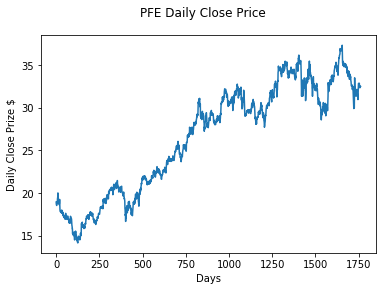

In [227]:
pfe_close = pfe_raw.close.values.astype('float32')
pfe_close = pfe_close.reshape(1762, 1)

plt.plot(pfe_close)
plt.xlabel("Days")
plt.ylabel('Daily Close Prize $')
plt.suptitle('PFE Daily Close Price')
plt.show()


### Data Preprocessing
We will predict the daily stock movement directionality, either up or down by comparing today's close price with yesterday's.

Now we have a binary outcome, up is coded as 1, down is coded as 0, the movement of the first day is defined by the comparison of the open and close price. 

If the between days close prices are equal, we consider it as "down". 

In [228]:
# pfe_raw.set_index([x for x in range(len(pfe_raw.index)) ])
s = pd.Series(range(len(pfe_raw.index)))
pfe_raw = pfe_raw.set_index(s)
pfe_raw.head(3)

,date,symbol,open,close,low,high,volume
0,2010-01-04,PFE,18.27,18.93,18.240000,18.940001,52086000.0
1,2010-01-05,PFE,18.92,18.66,18.549999,18.930000,43372800.0
2,2010-01-06,PFE,18.66,18.60,18.510000,18.809999,41405100.0


In [229]:
direction = []
for day in range(len(pfe_raw.index)):
    if day == 0:
        if (pfe_raw.loc[day, 'close'] - pfe_raw.loc[day, 'open']) > 0:
            direction.append(1)
        else:
            direction.append(0)
    else:
        if (pfe_raw.loc[day, 'close'] - pfe_raw.loc[(day-1), 'close']) > 0:
            direction.append(1)
        else:
            direction.append(0)
pfe_raw['direction'] = np.asarray(direction)
pfe_raw.head(3)

,date,symbol,open,close,low,high,volume,direction
0,2010-01-04,PFE,18.27,18.93,18.240000,18.940001,52086000.0,1
1,2010-01-05,PFE,18.92,18.66,18.549999,18.930000,43372800.0,0
2,2010-01-06,PFE,18.66,18.60,18.510000,18.809999,41405100.0,0


Split the data to training and test based on date. We want to use 80% training and 20% testing. Thus, the first 1410 days are for training, the remainings are for testing.

This type of split took the over-time correlation into consideration.

In [230]:
# the split data time point
# base = pfe_raw.loc[0, 'date']
# cut = datetime.strptime(base, '%Y-%m-%d') + timedelta(days=  np.round(0.8 * len(pfe_raw.index)) ) 

# cut_day = '2013-11-14'
# cut
cut_day = pfe_raw.loc[np.round(0.8 * len(pfe_raw.index)), 'date']
cut_day

'2015-08-11'

In [231]:
pfe = pfe_raw.copy()
days = pd.Series(pfe_raw.index)

In [232]:
# train
pfe['days'] = days
train = pfe[pfe['date'] < cut_day]
test = pfe[pfe['date'] >= cut_day]
print(train.shape)
print(train.head(3))

(1410, 9)
         date symbol   open  close        low       high      volume  \
0  2010-01-04    PFE  18.27  18.93  18.240000  18.940001  52086000.0   
1  2010-01-05    PFE  18.92  18.66  18.549999  18.930000  43372800.0   
2  2010-01-06    PFE  18.66  18.60  18.510000  18.809999  41405100.0   

   direction  days  
0          1     0  
1          0     1  
2          0     2  


## Train the model 

sklearn.svm.SVC

kernel : string, optional (default=’rbf’)

gamma: float, optional (default=’auto’)Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    

10-fold cross validation was used here.

In [233]:
# model fitting
X_train = train[['open','low','high','volume']]
y_train = train['direction']
n_samples, n_features = X_train.shape


In [234]:
# all data 
data_all = pfe.copy()
X = data_all[['open','low','high','volume']]
y = data_all['direction']

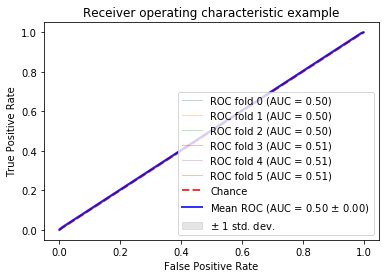

In [235]:
# modeling fitting
random_state = np.random.RandomState(0)
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(gamma='auto', probability = True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()



In [236]:
# test 
# X_test = train[['open','low','high','volume','days']]
# y_test = test['direction']


## Model Evaluation
Using the ROC curve

In [237]:
# # using the roc curve
# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])